# Feature selection (simple)

Download the fruits data [here](https://drive.google.com/file/d/1M8tiAWDZclABJN1Meq9oEHCLJTNyHdpP/view?usp=share_link)

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import time

In [3]:
data = pd.read_csv('fruits_data_ext.csv')
X, y = data.iloc[:,5:7],data['fruit_label']

In [4]:
np.random.seed(1)

In [5]:
## Add some noisy data to degrade features
random_columns = np.random.permutation(22)
random_features = np.random.RandomState(1000).uniform(0, 0.5, size=(X.shape[0], 20))
X = np.hstack((X, random_features))
X = X[:, random_columns]

print (X.shape, y.shape)

(177, 22) (177,)


In [6]:
# Normalize data to 0-1
X = MinMaxScaler(feature_range=(0,1)).fit_transform(X)

# Split dataset to select feature and evaluate the classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print ("\n", random_columns, "\n", np.arange(22))

(132, 22) (45, 22) (132,) (45,)

 [19 16  3 13 18 15 10  4  2 17  6  7  1 14  0 21 20  9  8 12 11  5] 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


## Classification using SVC

In [81]:
# Train a classifier using SVC on train data
classifier = SVC(kernel='linear')

start_time = time.time()
classifier.fit(X_train,y_train)
end_time = time.time()

print(f'Elapsed time: {format(end_time - start_time)}')

Elapsed time: 0.005248546600341797


Accuracy:0.6444444444444445


<Axes: >

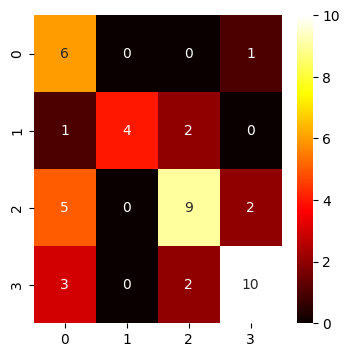

In [8]:
# Take predictions and compute some metrics (acc and CM)
predictions = classifier.predict(X_test)

acc_b = accuracy_score(y_test, predictions)
cm_b = confusion_matrix(y_test, predictions)

print(f"Accuracy:{acc_b}")

_,ax = plt.subplots(figsize=(4,4))
sns.heatmap(cm_b, cmap='hot', annot=True, ax=ax)

## Use Recursive Feature Elimination

### RFE -> [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE)


In [9]:
from sklearn.feature_selection import RFE

# Create a new SVC classifier
clf = SVC(kernel='linear')

# Compute RFE
rfe = RFE( estimator = clf , n_features_to_select = 2 )

best_features = rfe.fit( X_train , y_train)


In [10]:
# See results
print("Num Features: %d" % best_features.n_features_)
print("Selected Features: %s" % best_features.ranking_)
print("                 : %s" % np.arange(22))

Num Features: 2
Selected Features: [ 4 19 12 15  3 10 20 18 17  9 11  5  1 13  1 16  8  2 21  7  6 14]
                 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [11]:
list_best = np.where(best_features.ranking_ == 1)[0].tolist()
print (list_best)

[12, 14]


In [12]:
# Select best features
best_train = X_train[:,list_best]
best_test  = X_test[:,list_best]

print(best_train.shape, best_test.shape)

(132, 2) (45, 2)


In [13]:
# Retrain classifier on best features and make predictions
clf = SVC(kernel='linear')
clf.fit(best_train,y_train)

SVC(kernel='linear')

For Recursive feature elimination
Acc before: 0.6444444444444445, after: 0.6222222222222222


<Axes: >

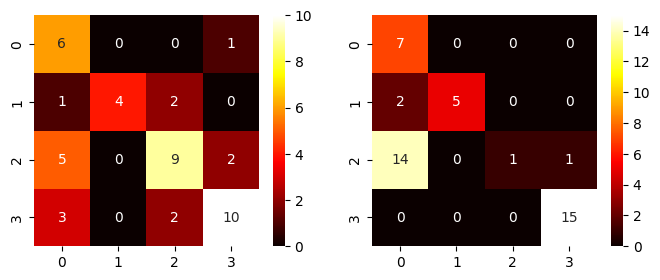

In [14]:
# Compute metrics
predictions = clf.predict(best_test)
acc_best = accuracy_score(y_test, predictions)
cm_best  = confusion_matrix(y_test, predictions)

print("For Recursive feature elimination")
print(f"Acc before: {acc_b}, after: {acc_best}")

_, axes=plt.subplots(1,2,figsize=(8,3))
sns.heatmap(cm_b, annot=True, cmap='hot', ax = axes[0])
sns.heatmap(cm_best, annot=True, cmap='hot', ax = axes[1])


## Use univariate selection to determine best features


### SelectKBest -> [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest)

Metrics: [F_classif (ANOVA)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif), [Chi2](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2), [mutual_information](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif)

In [42]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2,mutual_info_classif #ANOVA

skb = SelectKBest( f_classif , k = 4 )
skb.fit( X_train , y_train )

list_best = np.array(np.where(skb.get_support() == 1))[0].tolist()

print(list_best)

best_train = X_train[:,list_best]
best_test = X_test[:,list_best]

print (best_train.shape)

[0, 4, 12, 14]
(132, 4)


In [43]:
print("Num Features: %d" % best_train.shape[1])
print("Selected Features: %s" % np.array(skb.get_support(),dtype=int).tolist())
print("                 : %s" % np.arange(22))
print("                 : %s" % random_columns)

Num Features: 4
Selected Features: [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
                 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
                 : [19 16  3 13 18 15 10  4  2 17  6  7  1 14  0 21 20  9  8 12 11  5]


In [44]:
# Retrain classifier on best features and make predictions
clf = SVC(kernel = 'linear')
clf.fit(best_train, y_train)

SVC(kernel='linear')

For Recursive feature elimination
Acc before:0.7111111111111111, After0.7111111111111111


(Text(0.5, 1.0, 'Before'), Text(0.5, 1.0, 'After'))

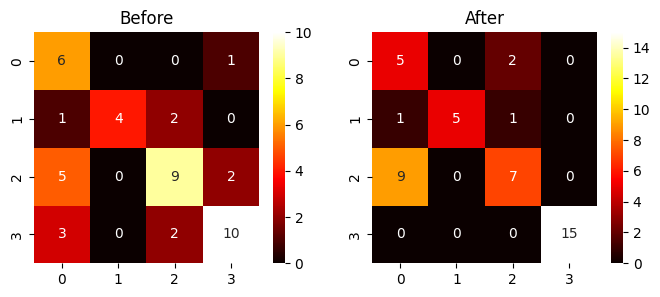

In [45]:
# Compute metrics
predictions = clf.predict(best_test)

acc_best = accuracy_score(y_test, predictions)
cm_best  = confusion_matrix(y_test, predictions)

print("For Recursive feature elimination")
print(f"Acc before:{acc_best}, After{acc_best}")

_, axes = plt.subplots(1,2, figsize=(8,3))

sns.heatmap(cm_b, annot=True, fmt='d', cmap='hot', ax = axes[0])
sns.heatmap(cm_best, annot=True, fmt='d', cmap='hot', ax = axes[1])

axes[0].set_title('Before'), axes[1].set_title('After')

### SelectPercentile -> [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile)

In [87]:
from sklearn.feature_selection import SelectPercentile, f_classif, chi2, mutual_info_classif #ANOVA

spc = SelectPercentile( mutual_info_classif , percentile = 20 )
spc.fit( X_train , y_train )

list_best = np.where(spc.get_support() == 1)[0].tolist()

best_train = X_train[:,list_best]
best_test = X_test[:,list_best]

print (best_train.shape)

(132, 5)


In [88]:
print("Num Features: %d" % best_train.shape[1])
print("Selected Features: %s" % np.array(spc.get_support(), dtype=int).tolist() )
print("                 : %s" % np.arange(22))
print("                 : %s" % random_columns)

Num Features: 5
Selected Features: [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
                 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
                 : [19 16  3 13 18 15 10  4  2 17  6  7  1 14  0 21 20  9  8 12 11  5]


In [ ]:
# Retrain classifier on best features and make predictions



In [ ]:
# Compute metrics
acc_best =
cm_best  =

print("For Recursive feature elimination")



## Use Metatransformer to determine best features

### SelectFromModel -> [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel)

In [89]:
from sklearn.feature_selection import SelectFromModel

# Create a new SVC classifier
clf = SVC(kernel='linear')

# Compute metatransformer
sfm = SelectFromModel(estimator = clf, max_features = 10)

best_features = sfm.fit(X_train, y_train)

In [93]:
# Transform best features

list_best = np.where(sfm.get_support() == 1)[0].tolist()

best_train = X_train[: , list_best]
best_test  = X_test[:, list_best]

print(best_train.shape, best_test.shape)

(132, 4) (45, 4)


In [95]:
print("Num Features: %d" % sfm.n_features_in_)
print("Selected Features: %s" % np.array(sfm.get_support(), dtype=int).tolist() )
print("                 : %s" % np.arange(22))
print("                 : %s" % random_columns)


Num Features: 22
Selected Features: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]
                 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
                 : [19 16  3 13 18 15 10  4  2 17  6  7  1 14  0 21 20  9  8 12 11  5]


In [96]:
# Retrain classifier on best features and make predictions
clf = SVC(kernel = 'linear')
clf.fit(best_train, y_train)

SVC(kernel='linear')

For SelectFromModel
Acc before:0.7777777777777778, After0.7777777777777778


(Text(0.5, 1.0, 'Before'), Text(0.5, 1.0, 'After'))

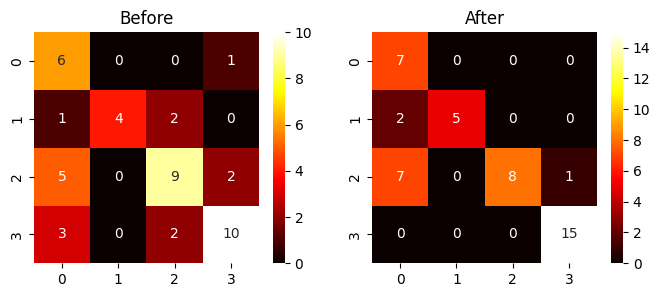

In [97]:
# Compute metrics
predictions = clf.predict(best_test)

acc_best = accuracy_score(y_test, predictions)
cm_best  = confusion_matrix(y_test, predictions)

print("For SelectFromModel")
print(f"Acc before:{acc_best}, After{acc_best}")

_, axes = plt.subplots(1,2, figsize=(8,3))

sns.heatmap(cm_b, annot=True, fmt='d', cmap='hot', ax = axes[0])
sns.heatmap(cm_best, annot=True, fmt='d', cmap='hot', ax = axes[1])

axes[0].set_title('Before'), axes[1].set_title('After')